<a href="https://colab.research.google.com/github/ariahosseini/TradML/blob/main/ML_CatBoost_ProjOne.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Settings

### Libs

In [82]:
!pip install -q catboost import_ipynb

In [83]:
# utils
import os, sys, warnings
import hyperopt
import import_ipynb
import pandas as pd
import numpy as np
from numpy.random import RandomState
# colab
from google.colab import drive
# catboost
from catboost.datasets import titanic
from catboost import CatBoostClassifier, MetricVisualizer, Pool, metrics, cv
# sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
# vis
import seaborn as sns
import matplotlib.pyplot as plt

### Setup

In [84]:
warnings.filterwarnings('ignore')

In [85]:
%matplotlib inline

In [86]:
# mount google drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [87]:
# working directory
working_dir = '/content/drive/MyDrive/Jupyter Notebooks/'
os.chdir(working_dir)

In [88]:
# load MachineLearningUtils module
from MachineLearningUtils import *

## Load Data

In [89]:
train_df, test_df = titanic()

## Understand Data

In [90]:
reduce_memory_usage(df=train_df, category=True)

Memory usage of dataframe is 0.081696 MB!
Memory usage after optimization is 0.080069 MB!
Decreased by 2.0%


In [91]:
summarize_columns(train_df)

,col_name,dtypes,missing,missing_percent,uniques,first_value,second_value,third_value
0,PassengerId,int16,0,0.0,891,1,2,3
1,Survived,int8,0,0.0,2,0,1,1
2,Pclass,int8,0,0.0,3,3,1,3
3,Name,category,0,0.0,891,"Braund, Mr. Owen Harris","Cumings, Mrs. John Bradley (Florence Briggs Th...","Heikkinen, Miss. Laina"
4,Sex,category,0,0.0,2,male,female,female
5,Age,float16,177,19.9,88,22.0,38.0,26.0
6,SibSp,int8,0,0.0,7,1,1,0
7,Parch,int8,0,0.0,7,0,0,0
8,Ticket,category,0,0.0,681,A/5 21171,PC 17599,STON/O2. 3101282
9,Fare,float16,0,0.0,242,7.25,71.3125,7.925781


In [92]:
train_df, test_df = train_df.set_index("PassengerId"), test_df.set_index("PassengerId")

In [93]:
train_df.drop(["Name", "Ticket", "Cabin"], axis=1, inplace=True)
test_df.drop(["Name", "Ticket", "Cabin"], axis=1, inplace=True)

In [94]:
summarize_columns(train_df)

,col_name,dtypes,missing,missing_percent,uniques,first_value,second_value,third_value
0,Survived,int8,0,0.0,2,0,1,1
1,Pclass,int8,0,0.0,3,3,1,3
2,Sex,category,0,0.0,2,male,female,female
3,Age,float16,177,19.9,88,22.0,38.0,26.0
4,SibSp,int8,0,0.0,7,1,1,0
5,Parch,int8,0,0.0,7,0,0,0
6,Fare,float16,0,0.0,242,7.25,71.3125,7.925781
7,Embarked,category,2,0.2,3,S,C,S


In [95]:
display_df(train_df)

Dataframe:  
num_rows = 891 
num_cols = 8


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
1,0,3,male,22.0,1,0,7.250000,S
2,1,1,female,38.0,1,0,71.312500,C
3,1,3,female,26.0,0,0,7.925781,S
4,1,1,female,35.0,1,0,53.093750,S
5,0,3,male,35.0,0,0,8.046875,S


Info:
<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   Survived  891 non-null    int8    
 1   Pclass    891 non-null    int8    
 2   Sex       891 non-null    category
 3   Age       714 non-null    float16 
 4   SibSp     891 non-null    int8    
 5   Parch     891 non-null    int8    
 6   Fare      891 non-null    float16 
 7   Embarked  889 non-null    category
dtypes: category(2), float16(2), int8(4)
memory usage: 10.7 KB
Number of null data points:
Age         177
Embarked      2
dtype: int64


In [96]:
cols = list(train_df.columns)
numerical_features= ["Age", "Fare"]
categorical_features = [col for col in cols if col not in numerical_features]

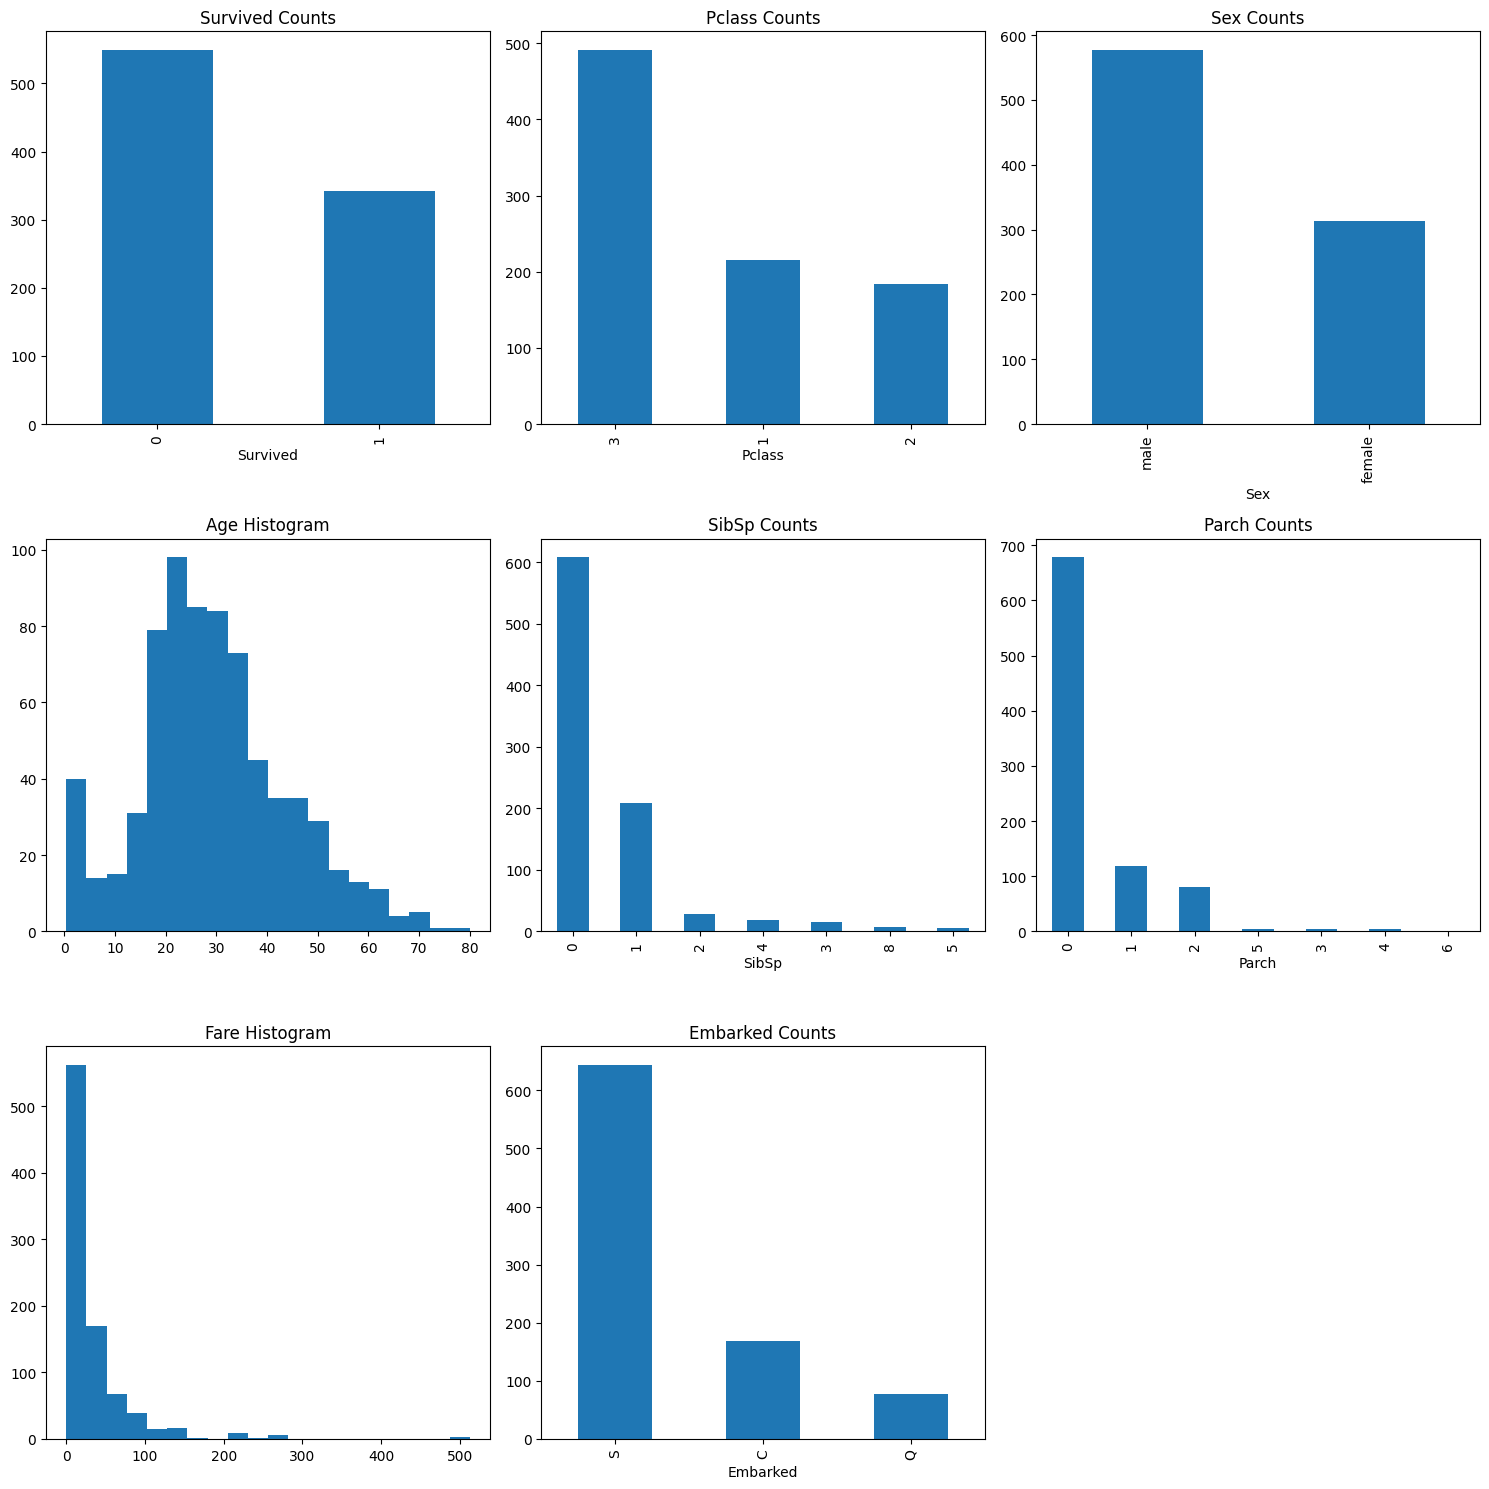

In [97]:
plot_variables(df=train_df, vars_to_plot=cols, cts_vars=numerical_features, num_cols=3, hist_num_bins=20)

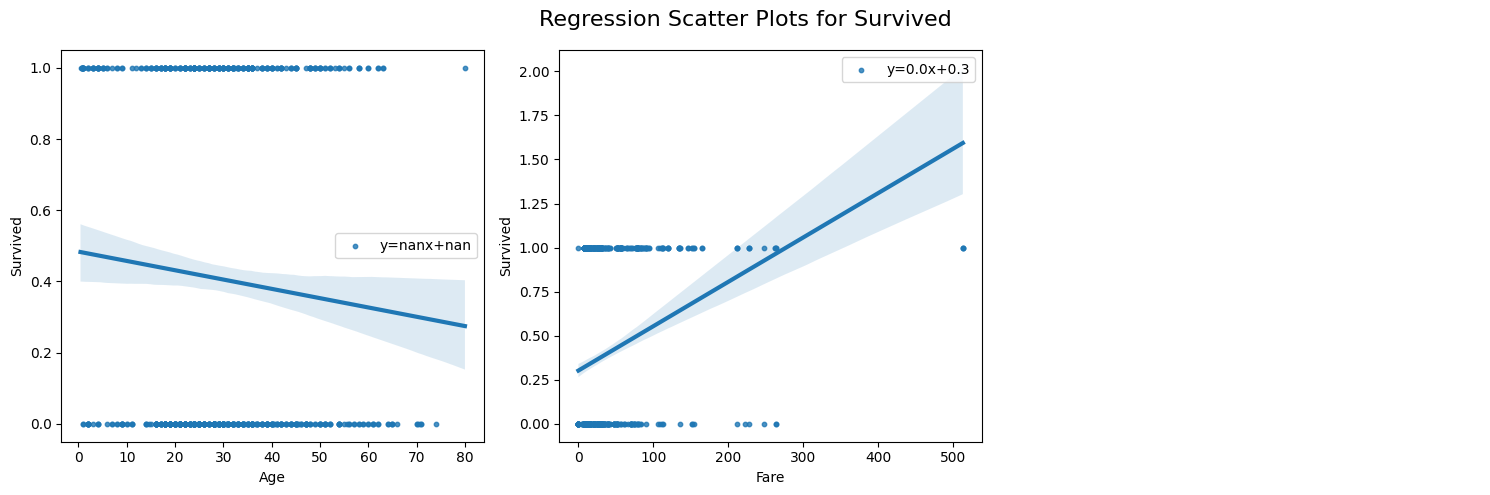

In [101]:
plot_regs(df=train_df, cts_vars=numerical_features, response="Survived",
          num_cols=3, dot_size=10, line_width=3)

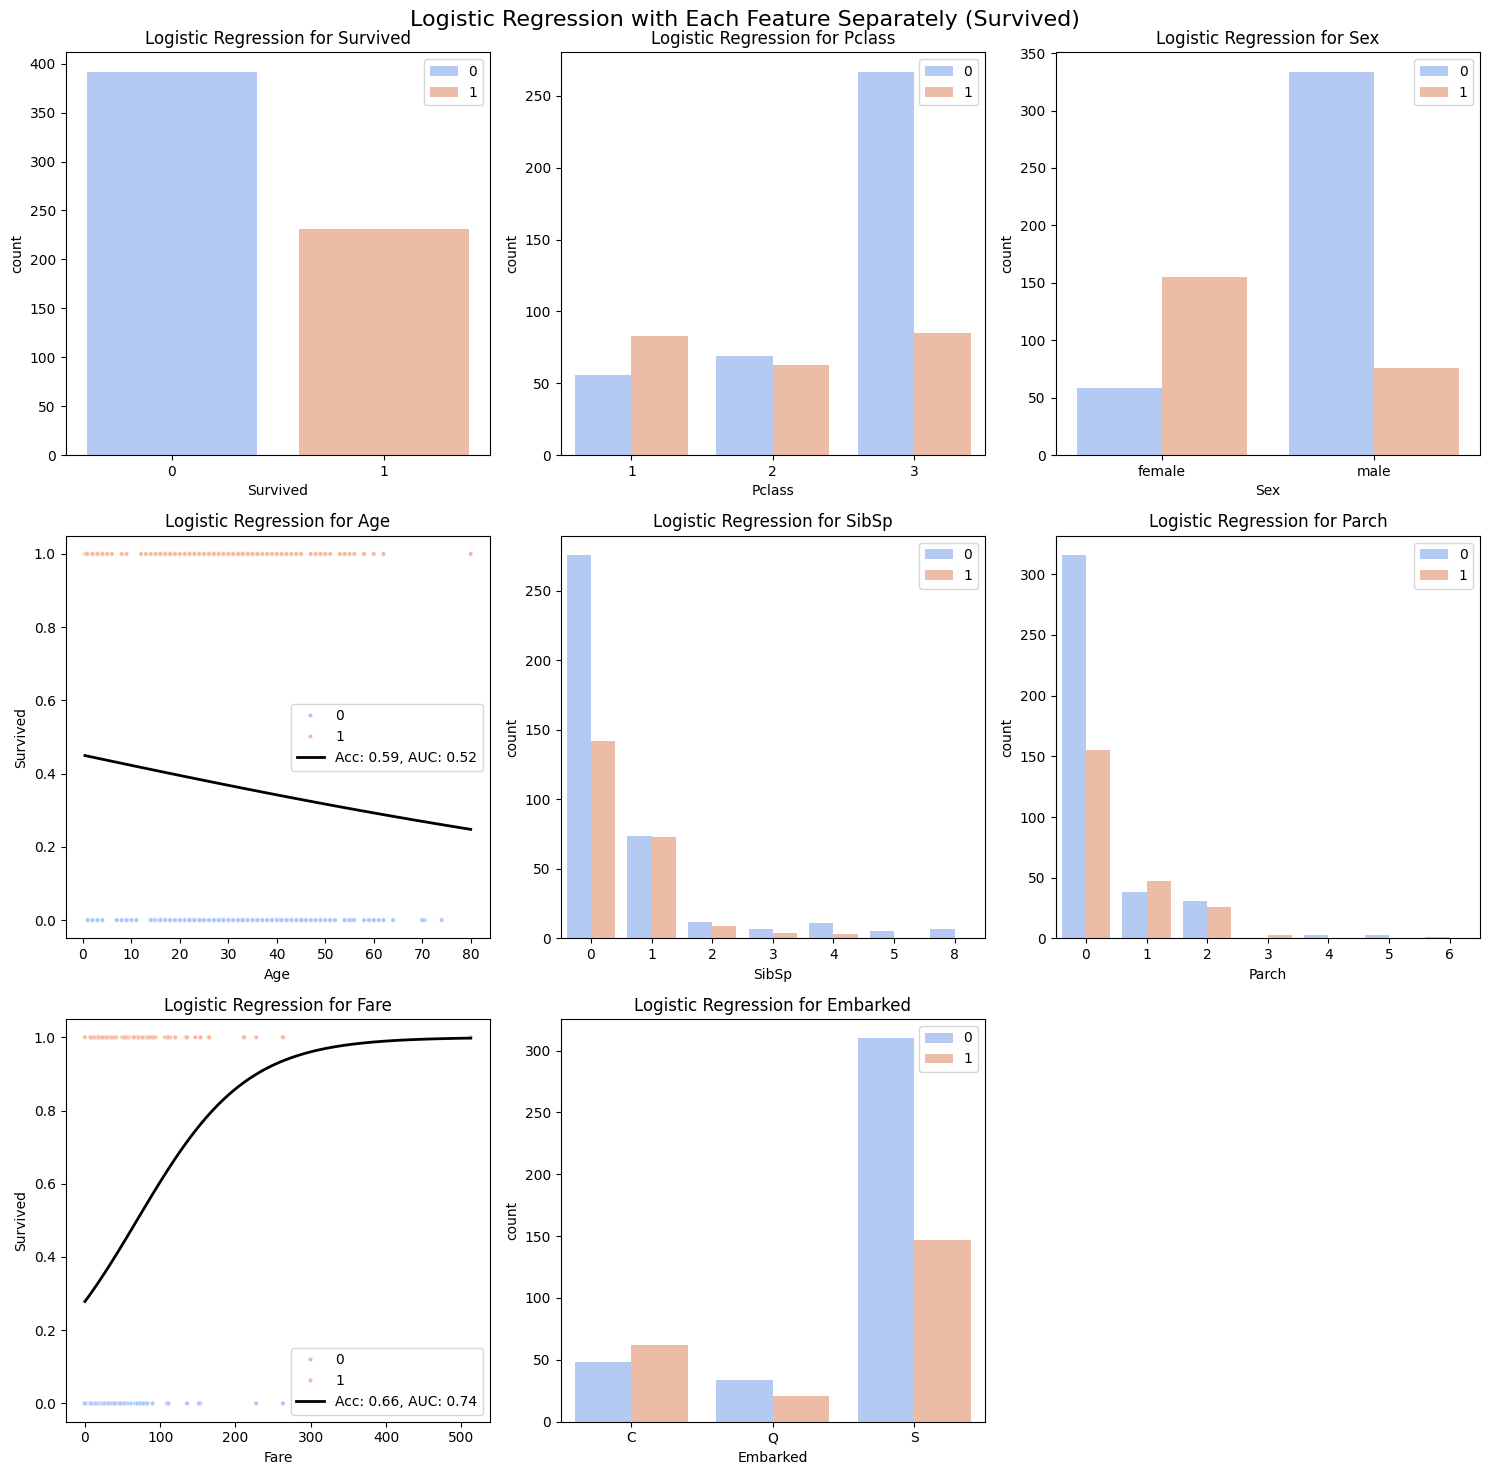

In [102]:
plot_clfs(df=train_df, feature_vars=cols, response="Survived", num_cols=3, dot_size=10)

## CatBoost

### Load Data

In [103]:
train_df, test_df = titanic()

### Handle Missing Values

<Axes: xlabel='Num_missed_values'>

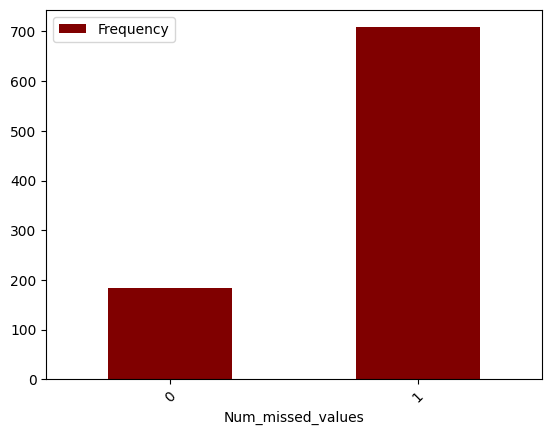

In [104]:
def count_rows_with_missing_values(dataframe):
    missing_values_per_row = dataframe.isnull().sum(axis=1)
    _bins = np.arange(int(min(missing_values_per_row)), int(max(missing_values_per_row)) + 1)
    hist_values, bins = np.histogram(missing_values_per_row, bins=_bins)
    bins_percent = [_ for _ in bins]
    hist_df = pd.DataFrame({'Num_missed_values': bins_percent[:-1], 'Frequency': hist_values})
    return hist_df
result = count_rows_with_missing_values(train_df)
result.plot.bar(x='Num_missed_values', y='Frequency', rot=45, width=0.5, color='maroon')

In [105]:
print("Number of null values:")
null_vals = train_df.isnull().sum(axis=0)
null_vals[null_vals!=0]

Number of null values:


,0
Age,177
Cabin,687
Embarked,2


In [106]:
train_df.fillna(-9999, inplace=True)
test_df.fillna(-9999, inplace=True)

### Dataset and Target Value

In [107]:
features = train_df.drop("Survived", axis=1)
target = train_df.Survived

In [108]:
cat_features = np.where(features.dtypes!=float)[0]

In [109]:
X_train, X_validation, y_train, y_validation = train_test_split(features,
                                                                target,
                                                                train_size=0.75,
                                                                random_state=42)
X_test = test_df

### Define Model

In [110]:
model = CatBoostClassifier(custom_loss=[metrics.Accuracy()],
                           random_seed=42,
                           logging_level='Silent',
                           early_stopping_rounds=50
                           )

In [111]:
model.fit(X_train,
          y_train,
          cat_features=cat_features,
          eval_set=(X_validation, y_validation),
          logging_level='Silent',
          plot=True
          )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

### Cross Validation

In [112]:
cv_params = model.get_params()
cv_params

{'random_seed': 42,
 'logging_level': 'Silent',
 'custom_loss': ['Accuracy'],
 'early_stopping_rounds': 50}

In [113]:
cv_params.update({'loss_function': metrics.Logloss()})
cv_data = cv(Pool(features, target, cat_features=cat_features), cv_params, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [114]:
cv_data.head()

,iterations,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std,test-Accuracy-mean,test-Accuracy-std,train-Accuracy-mean,train-Accuracy-std
0,0,0.676936,0.001133,0.676477,0.003152,0.794613,0.003367,0.798541,0.020778
1,1,0.660661,0.000697,0.659381,0.003172,0.795735,0.030365,0.812009,0.010286
2,2,0.646543,0.001920,0.645228,0.004168,0.803591,0.028636,0.812009,0.014119
3,3,0.632857,0.003376,0.631048,0.004247,0.804714,0.026725,0.812570,0.012179
4,4,0.619750,0.004936,0.617523,0.005041,0.803591,0.026153,0.813692,0.011459


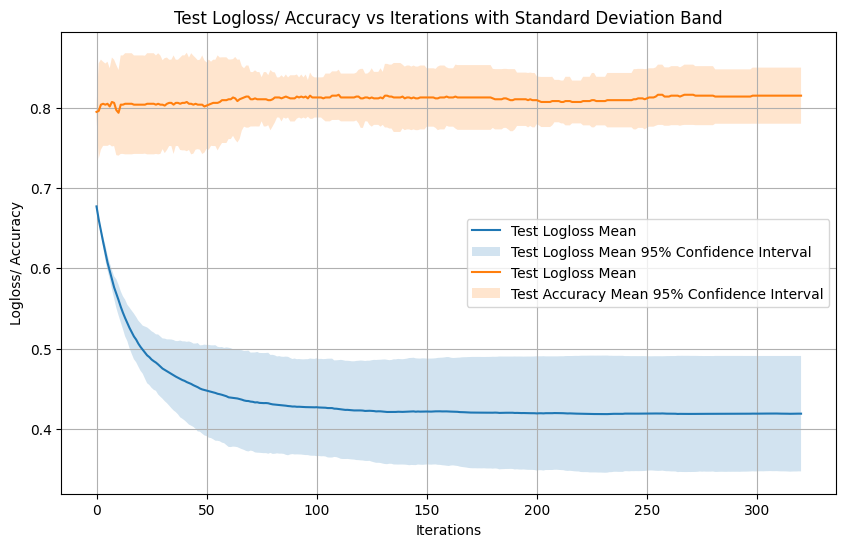

In [115]:
plt.figure(figsize=(10, 6))
plt.plot(cv_data.iterations, cv_data['test-Logloss-mean'], label='Test Logloss Mean')
plt.fill_between(cv_data.iterations,
                 cv_data['test-Logloss-mean'] - 1.96 * cv_data['test-Logloss-std'],
                 cv_data['test-Logloss-mean'] + 1.96 * cv_data['test-Logloss-std'],
                 alpha=0.2,
                 label='Test Logloss Mean 95% Confidence Interval')

plt.plot(cv_data.iterations, cv_data['test-Accuracy-mean'], label='Test Logloss Mean')
plt.fill_between(cv_data.iterations,
                 cv_data['test-Accuracy-mean'] - 1.96 * cv_data['test-Accuracy-std'] ,
                 cv_data['test-Accuracy-mean'] + 1.96 * cv_data['test-Accuracy-std'] ,
                 alpha=0.2,
                 label='Test Accuracy Mean 95% Confidence Interval')

plt.xlabel('Iterations')
plt.ylabel('Logloss/ Accuracy')
plt.title('Test Logloss/ Accuracy vs Iterations with Standard Deviation Band')
plt.legend()
plt.grid(True)
plt.show()

In [116]:
print('Best validation accuracy score: {:.2f}±{:.2f} on step {}'.format(
    np.max(cv_data['test-Accuracy-mean']),
    cv_data['test-Accuracy-std'][np.argmax(cv_data['test-Accuracy-mean'])],
    np.argmax(cv_data['test-Accuracy-mean'])
))
print('Precise validation accuracy score: {}'.format(np.max(cv_data['test-Accuracy-mean'])))

Best validation accuracy score: 0.82±0.02 on step 110
Precise validation accuracy score: 0.8159371492704827


In [117]:
predictions = model.predict(X_test)
predictions_probs = model.predict_proba(X_test)
print(predictions[:10])
print(predictions_probs[:10])

[0 0 0 0 1 0 1 0 1 0]
[[0.85963998 0.14036002]
 [0.73941007 0.26058993]
 [0.88495066 0.11504934]
 [0.89117181 0.10882819]
 [0.36045113 0.63954887]
 [0.90335455 0.09664545]
 [0.35404814 0.64595186]
 [0.76848491 0.23151509]
 [0.40015216 0.59984784]
 [0.94172558 0.05827442]]


### Model Configs

In [118]:
params = {
    'iterations': 500,
    'learning_rate': 0.1,
    'eval_metric': metrics.Accuracy(),
    'random_seed': 42,
    'logging_level': 'Silent',
    'use_best_model': False
    }
train_pool = Pool(X_train, y_train, cat_features=cat_features)
validate_pool = Pool(X_validation, y_validation, cat_features=cat_features)
model = CatBoostClassifier(**params)
model.fit(train_pool, eval_set=validate_pool)
acc = accuracy_score(y_validation, model.predict(X_validation))
print('Model validation accuracy: {:.4}'.format(acc))
print('Model tree count: {}'.format(model.tree_count_))

Model validation accuracy: 0.7982
Model tree count: 500


In [119]:
params.update({'use_best_model': True})
model = CatBoostClassifier(**params)
model.fit(train_pool, eval_set=validate_pool)
acc = accuracy_score(y_validation, model.predict(X_validation))
print('Model validation accuracy: {:.4}'.format(acc))
print('Model tree count: {}'.format(model.tree_count_))

Model validation accuracy: 0.8251
Model tree count: 42


In [120]:
params.update({
    'use_best_model': False,
    'od_type': 'Iter',
    'od_wait': 40
    })
model = CatBoostClassifier(**params)
model.fit(train_pool, eval_set=validate_pool);
acc = accuracy_score(y_validation, model.predict(X_validation))
print('Model validation accuracy: {:.4}'.format(acc))
print('Model tree count: {}'.format(model.tree_count_))

Model validation accuracy: 0.8072
Model tree count: 82


In [121]:
params.update({'iterations': 100})
model = CatBoostClassifier(**params).fit(X_train, y_train, cat_features)
acc = accuracy_score(y_validation, model.predict(X_validation))
print('Model validation accuracy no warm starting: {:.4}'.format(acc))
# warm starting
baseline = model.predict(X_train, prediction_type='RawFormulaVal')
model.fit(X_train, y_train, cat_features, baseline=baseline)
acc = accuracy_score(y_validation, model.predict(X_validation))
print('Model validation accuracy with warm starting: {:.4}'.format(acc))

Model validation accuracy no warm starting: 0.8251
Model validation accuracy with warm starting: 0.6413


In [122]:
params.update({
    'use_best_model': False,
    'iterations': 100,
    'learning_rate': 0.5,
    'logging_level': 'Silent',
    })
init_model = CatBoostClassifier(**params).fit(train_pool,
                                              eval_set=validate_pool,
                                              save_snapshot=True)
acc = accuracy_score(y_validation, init_model.predict(X_validation))
print('Initial model validation accuracy: {:.4}'.format(acc))

params.update({
    'iterations': 10,
    'learning_rate': 0.1,
    })
secondary_model = CatBoostClassifier(**params).fit(train_pool,
                                                   eval_set=validate_pool,
                                                   save_snapshot=True)
acc = accuracy_score(y_validation, secondary_model.predict(X_validation))
print('Secondary model validation accuracy: {:.4}'.format(acc))

Initial model validation accuracy: 0.7982
Secondary model validation accuracy: 0.7982


In [123]:
class LoglossObjective(object):
    def calc_ders_range(self, approxes, targets, weights):
      '''
        approxes, targets, weights are indexed containers of floats
        (containers which have only __len__ and __getitem__ defined).
        weights parameter can be None.

        To understand what these parameters mean, assume that there is
        a subset of your dataset that is currently being processed.
        approxes contains current predictions for this subset,
        targets contains target values you provided with the dataset.

        This function should return a list of pairs (der1, der2), where
        der1 is the first derivative of the loss function with respect
        to the predicted value, and der2 is the second derivative.

        In our case, logloss is defined by the following formula:
        target * log(sigmoid(approx)) + (1 - target) * (1 - sigmoid(approx))
        where sigmoid(x) = 1 / (1 + e^(-x)).
      '''

      assert len(approxes) == len(targets)
      if weights is not None:
        assert len(weights) == len(approxes)
      result = []
      for index in range(len(targets)):
        e = np.exp(approxes[index])
        p = e / (1 + e)
        der1 = (1 - p) if targets[index] > 0.0 else -p
        der2 = -p * (1 - p)
        if weights is not None:
          der1 *= weights[index]
          der2 *= weights[index]

        result.append((der1, der2))
      return result

model = CatBoostClassifier(
    iterations=10,
    random_seed=42,
    loss_function=LoglossObjective(),
    eval_metric=metrics.Logloss()
    )
model.fit(train_pool)
preds_raw = model.predict(X_test, prediction_type='RawFormulaVal')

0:	learn: 0.6827074	total: 240ms	remaining: 2.16s
1:	learn: 0.6723302	total: 243ms	remaining: 972ms
2:	learn: 0.6619449	total: 245ms	remaining: 571ms
3:	learn: 0.6521466	total: 247ms	remaining: 370ms
4:	learn: 0.6435227	total: 249ms	remaining: 249ms
5:	learn: 0.6353848	total: 252ms	remaining: 168ms
6:	learn: 0.6277210	total: 254ms	remaining: 109ms
7:	learn: 0.6210282	total: 256ms	remaining: 64ms
8:	learn: 0.6141958	total: 259ms	remaining: 28.8ms
9:	learn: 0.6073236	total: 262ms	remaining: 0us


In [124]:
class LoglossMetric(object):
    def get_final_error(self, error, weight):
        return error / (weight + 1e-38)

    def is_max_optimal(self):
        return False

    def evaluate(self, approxes, target, weight):
        '''
          approxes is a list of indexed containers
          (containers with only __len__ and __getitem__ defined),
          one container per approx dimension.
          Each container contains floats.
          weight is a one dimensional indexed container.
          target is float.

          weight parameter can be None.
          Returns pair (error, weights sum)
        '''

        assert len(approxes) == 1
        assert len(target) == len(approxes[0])

        approx = approxes[0]

        error_sum = 0.0
        weight_sum = 0.0

        for i in range(len(approx)):
            w = 1.0 if weight is None else weight[i]
            weight_sum += w
            error_sum += -w * (target[i] * approx[i] - np.log(1 + np.exp(approx[i])))

        return error_sum, weight_sum

model = CatBoostClassifier(
    iterations=10,
    random_seed=42,
    loss_function=metrics.Logloss(),
    eval_metric=LoglossMetric()
    )
model.fit(train_pool)
preds_raw = model.predict(X_test, prediction_type='RawFormulaVal')

Learning rate set to 0.5
0:	learn: 0.5521578	total: 266ms	remaining: 2.4s
1:	learn: 0.4885686	total: 273ms	remaining: 1.09s
2:	learn: 0.4607664	total: 277ms	remaining: 647ms
3:	learn: 0.4418819	total: 279ms	remaining: 419ms
4:	learn: 0.4278162	total: 281ms	remaining: 281ms
5:	learn: 0.4151036	total: 283ms	remaining: 189ms
6:	learn: 0.4099336	total: 285ms	remaining: 122ms
7:	learn: 0.4095363	total: 287ms	remaining: 71.7ms
8:	learn: 0.4032867	total: 289ms	remaining: 32.1ms
9:	learn: 0.3929586	total: 291ms	remaining: 0us


In [125]:
model = CatBoostClassifier(iterations=10,
                           random_seed=42,
                           logging_level='Silent').fit(train_pool)
ntree_start, ntree_end, eval_period = 3, 9, 2
pred_iter = model.staged_predict(validate_pool,
                                 'Probability',
                                 ntree_start,
                                 ntree_end,
                                 eval_period)
for preds, tree_count in zip(pred_iter, range(ntree_start,
                                              ntree_end,
                                              eval_period)):
    print('First class probabilities using the first {} trees: {}'.format(tree_count, preds[:5, 1]))

First class probabilities using the first 3 trees: [0.53597869 0.41039128 0.42057479 0.64281031 0.46576685]
First class probabilities using the first 5 trees: [0.63722688 0.42492029 0.46209302 0.70926021 0.44280772]
First class probabilities using the first 7 trees: [0.66964764 0.42409144 0.46124982 0.76101033 0.47205986]


In [126]:
model = CatBoostClassifier(iterations=50,
                           random_seed=42,
                           logging_level='Silent').fit(train_pool)
feature_importances = model.get_feature_importance(train_pool)
feature_names = X_train.columns
for score, name in sorted(zip(feature_importances, feature_names), reverse=True):
    print('{}: {}'.format(name, score))

Sex: 59.004092014268586
Pclass: 16.340887169747035
Ticket: 6.028107169932204
Cabin: 3.8347242202560192
Fare: 3.712969667934384
Age: 3.484451204182482
Parch: 3.378089740355865
Embarked: 2.3139994072899555
SibSp: 1.9026794060334504
PassengerId: 0.0
Name: 0.0


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

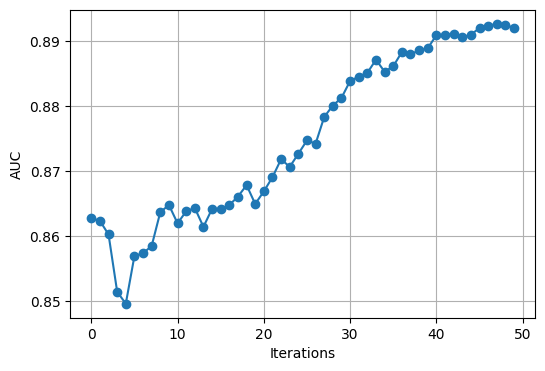

In [127]:
model = CatBoostClassifier(iterations=50,
                           random_seed=42,
                           logging_level='Silent').fit(train_pool)
eval_metrics = model.eval_metrics(validate_pool, [metrics.AUC()], plot=True)
plt.figure(figsize=(6, 4))
plt.plot(eval_metrics['AUC'], "o-")
plt.xlabel('Iterations')
plt.ylabel('AUC')
plt.grid(True)
plt.show()

In [128]:
model = CatBoostClassifier(iterations=100,
                           depth=5,
                           train_dir='model/',
                           logging_level='Silent')
model.fit(train_pool, eval_set=validate_pool)
widget = MetricVisualizer(['model'])
widget.start()

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [129]:
model = CatBoostClassifier(iterations=10,
                           random_seed=42,
                           logging_level='Silent').fit(train_pool)
model.save_model('catboost_model.dump')
model.load_model('catboost_model.dump')

### Hyperparameters Optimizer

In [131]:
def hyperopt_objective(params):
    model = CatBoostClassifier(
        l2_leaf_reg=int(params['l2_leaf_reg']),
        learning_rate=params['learning_rate'],
        iterations=500,
        eval_metric=metrics.Accuracy(),
        random_seed=42,
        verbose=False,
        loss_function=metrics.Logloss(),
        )

    cv_data = cv(Pool(X_train, y_train, cat_features=cat_features),
                 model.get_params(),
                 logging_level='Silent'
                 )
    best_accuracy = np.max(cv_data['test-Accuracy-mean'])

    return 1 - best_accuracy

params_space = {
    'l2_leaf_reg': hyperopt.hp.qloguniform('l2_leaf_reg', 0, 2, 1),
    'learning_rate': hyperopt.hp.uniform('learning_rate', 1e-3, 5e-1),
    }

trials = hyperopt.Trials()

opt_vals = hyperopt.fmin(
    hyperopt_objective,
    space=params_space,
    algo=hyperopt.tpe.suggest,
    max_evals=50,
    trials=trials,
    )
print(opt_vals)

100%|██████████| 50/50 [10:52<00:00, 13.05s/trial, best loss: 0.1766141141141141]
{'l2_leaf_reg': 2.0, 'learning_rate': 0.039108113393117594}


In [132]:
model = CatBoostClassifier(
    l2_leaf_reg=int(opt_vals['l2_leaf_reg']),
    learning_rate=opt_vals['learning_rate'],
    iterations=500,
    eval_metric=metrics.Accuracy(),
    random_seed=42,
    verbose=False,
    loss_function=metrics.Logloss(),
    )
cv_data = cv(Pool(X_train, y_train, cat_features=cat_features), model.get_params())
print('Precise validation accuracy score: {}'.format(np.max(cv_data['test-Accuracy-mean'])))
model.fit(X_train, y_train, cat_features=cat_features)
submisstion = pd.DataFrame()
submisstion['PassengerId'] = X_test['PassengerId']
submisstion['Survived'] = model.predict(X_test)
submisstion.to_csv('submission.csv', index=False)
submisstion.head()

Training on fold [0/3]

bestTest = 0.8125
bestIteration = 1

Training on fold [1/3]

bestTest = 0.8333333333
bestIteration = 117

Training on fold [2/3]

bestTest = 0.8288288288
bestIteration = 98

Precise validation accuracy score: 0.8233858858858859


,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
